# **Milestone 2, GROUP 12**

*Some settings:*

In [1]:
import psycopg2
import pandas as pd
from IPython.display import HTML, Math
display(HTML("<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default'></script>"))

In [4]:
# setup a password `postgres` for username `postgres`
!sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD 'postgres';"
# setup a database with name `m2` to be used
!sudo -u postgres psql -U postgres -c 'DROP DATABASE IF EXISTS m2;'
!sudo -u postgres psql -U postgres -c 'CREATE DATABASE m2;'

ALTER ROLE
NOTICE:  database "m2" does not exist, skipping
DROP DATABASE
CREATE DATABASE


## Task 0 Load csv file

We loaded entire csv (`1mio-raw.csv`) to table `news`:

```
CREATE TABLE news
(
	index TEXT,id TEXT,domain TEXT,type TEXT,url TEXT,content TEXT,
	scraped_at DATE,inserted_at DATE,updated_at DATE,
	title TEXT,authors TEXT,keywords TEXT,
	meta_keywords TEXT,meta_description TEXT,tags TEXT,summary TEXT,source TEXT
);
```
Attribute such as `ID` shoud be `INTEGER NOT NULL` since we decided to set it as PK for futher use, but we found that there are some empty rows and unexpected strings in it. We therefore set it to `TEXT` firstly and changed it back to `INTEGER NOT NULL` and `INTEGER` after loading.

In [3]:
# connect database
con = psycopg2.connect(database='postgres', user='postgres',password='postgres',host="127.0.0.1", port="5432")
cur = con.cursor()
# creat allnews table
cur.execute("DROP table IF EXISTS news")
cur.execute("CREATE TABLE news(index text,id text,domain TEXT,type TEXT,url TEXT,content TEXT,scraped_at DATE,inserted_at DATE,updated_at DATE,title TEXT,authors TEXT,keywords TEXT,meta_keywords TEXT,meta_description TEXT,tags TEXT,summary TEXT,source TEXT)")
# load entire csv
cur.execute("COPY news FROM '/mnt/d/news/data.csv' DELIMITER ',' CSV HEADER ENCODING 'UTF8'")
# delete NULL rows
cur.execute('DELETE FROM news WHERE id IS NULL')
# delete strings in ID
cur.execute("delete FROM news WHERE id ~* '^[a-z]'") 
# set INTEGER for ID
cur.execute('ALTER TABLE news ALTER COLUMN id TYPE integer USING (id::integer)')
con.commit()
con.close

COPY 1000000


In [4]:
# count news
con = psycopg2.connect(database='postgres', user='postgres',password='postgres',host="127.0.0.1", port="5432")
cur = con.cursor()
cur.execute('select count(id) from news')
all_news=cur.fetchall()
print(all_news[0][0],'news in total')
cur.execute('select distinct(authors,domain,title,content,meta_description,meta_keywords,tags) from news')
dis_news=cur.fetchall()
print(len(dis_news),'news are distinct')

999934 news in total
904911 news are distinct


We loaded 999934 news in total, and there are 904911 distinct news.  


Now we delete duplicate news.

In [ ]:
# count each type
con = psycopg2.connect(database='postgres', user='postgres',password='postgres',host="127.0.0.1", port="5432")
cur = con.cursor()
cur.execute('select type, count(type) from news group by type order by type')
count_type = pd.DataFrame(cur.fetchall(), columns=['type', 'count'])

In [13]:
# remove dup news
con = psycopg2.connect(database='postgres', user='postgres',password='postgres',host="127.0.0.1", port="5432")
cur = con.cursor()
cur.execute('delete from news n where n.id = any(array (select id from (select row_number() over (partition by  authors,domain,title,content,meta_description,meta_keywords,tags), id from news) t where t.row_number > 1))')
cur.execute('select count(id) from news')
removed_news=cur.fetchall()
con.commit()
con.close
print(all_news[0][0]-removed_news[0][0],'dup news are removed')

95023 dup news are removed


In [14]:
# count types after removed dup news
con = psycopg2.connect(database='postgres', user='postgres',password='postgres',host="127.0.0.1", port="5432")
cur = con.cursor()
cur.execute('select type, count(type) from news group by type order by type')
count_after = pd.DataFrame(cur.fetchall(), columns=['type', 'after removed'])
count_type['after removed']=count_after[['after removed']]
count_type['Subtracted']=count_type.apply(lambda x: x['count'] - x['after removed'], axis=1)
count_type=count_type.drop(index=12)
count_type['Subtracted %']=count_type.apply(lambda x: 100*x['Subtracted']/x['count'], axis=1)
count_type

,type,count,after removed,Subtracted,Subtracted %
0,bias,136381,124074,12307,9.023984
1,clickbait,21723,20917,806,3.710353
2,conspiracy,109793,76658,33135,30.179520
3,fake,123929,121772,2157,1.740513
4,hate,3619,3567,52,1.436861
5,junksci,17408,15029,2379,13.666131
6,political,289666,258215,31451,10.857677
7,reliable,6601,5417,1184,17.936676
8,rumor,46524,46466,58,0.124667
9,satire,14263,14252,11,0.077123


In [ ]:
# 其实重复新闻也不一定是“假新闻”的特征，可能是之前的数据集不够大。

## **Task 1**


We found that  
1. There are around one million news in dataset, but only 394 distinct doamins and 12 types.    
2. One domain only contribuates to one type (unique), but one type has many domains.    
3. Three dates (scraped_at,inserted_at,updated_at) are identical since we use `DATE` rather than `TIMESTAMP`.   
4. Summary,source,keywords are NULL.

We designed following shcema: 


![image.png](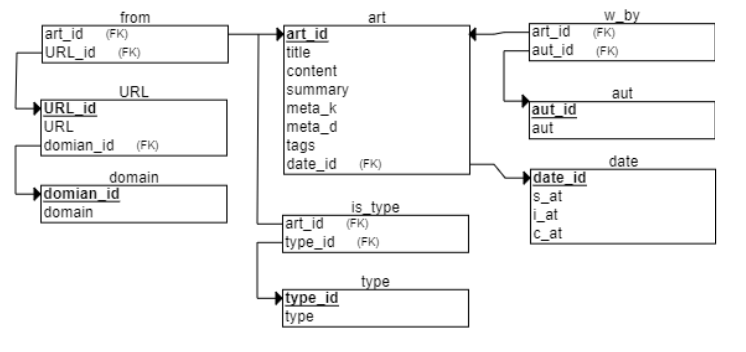
)

### **1.1** Creat table `URL`

In [ ]:
# creat table URL
con = psycopg2.connect(database='postgres', user='postgres',password='postgres',host="127.0.0.1", port="5432")
cur = con.cursor()
cur.execute("DROP table IF EXISTS URL")
cur.execute("SELECT id,URL,domain into URL from news")
# rename id to url_id
cur.execute('ALTER TABLE URL RENAME COLUMN id TO url_id')
# insert domain_id
cur.execute('ALTER TABLE URL ADD column d_id integer')
cur.execute('UPDATE URL SET d_id = domain.d_id FROM domain WHERE URL.domain=domain.domain')
cur.execute('ALTER TABLE URL DROP COLUMN domain')
# set url_id as PK
cur.execute('ALTER TABLE URL ADD PRIMARY KEY (url_id)')
con.commit()

### **1.2** Creat table `domain`

In [15]:
# creat table domain
con = psycopg2.connect(database='postgres', user='postgres',password='postgres',host="127.0.0.1", port="5432")
cur = con.cursor()
cur.execute("DROP table IF EXISTS domain")
cur.execute("SELECT id,domain into domain from news;")
# delete dup domains
cur.execute('delete from domain d where d.id not in (select min(id) from domain group by domain)')
# drop id
cur.execute('ALTER TABLE domain DROP COLUMN id')
# gen domain_id
cur.execute('ALTER TABLE domain add COLUMN d_id SERIAL UNIQUE')
# set domain as PK
cur.execute('ALTER TABLE domain ADD PRIMARY KEY(d_id)')
con.commit()

### **1.3** Creat table `date`

In [16]:
# creat table date
con = psycopg2.connect(database='postgres', user='postgres',password='postgres',host="127.0.0.1", port="5432")
cur = con.cursor()
cur.execute("DROP table IF EXISTS date")
cur.execute("SELECT id,inserted_at,updated_at into date from news")
# delete dup date
cur.execute('delete from date d where d.id not in (select min(id) from date group by scraped_at,inserted_at,updated_at)')
# add date_id
cur.execute('ALTER TABLE date DROP COLUMN id')
cur.execute('CREATE SEQUENCE date_id')
cur.execute("ALTER TABLE date ADD COLUMN date_id integer NOT NULL DEFAULT nextval('date_id')")
cur.execute('ALTER SEQUENCE date_id OWNED BY date.date_id')
# set date_id as PK
cur.execute('ALTER TABLE date ADD PRIMARY KEY (date_id)')
con.commit()

### **1.4** Creat table `article`

In [17]:
# ctable article
con = psycopg2.connect(database='postgres', user='postgres',password='postgres',host="127.0.0.1", port="5432")
cur = con.cursor()
cur.execute("DROP table IF EXISTS article")
cur.execute("SELECT id,title,content,scraped_at,inserted_at,updated_at,meta_keywords,meta_description,tags into article from news")
# insert date_id
cur.execute('ALTER TABLE article ADD column date_id integer')
cur.execute('UPDATE article SET date_id = date.date_id FROM date WHERE article.scraped_at=date.scraped_at and article.inserted_at=date.inserted_at and article.updated_at=date.updated_at')
cur.execute('ALTER TABLE article DROP COLUMN scraped_at,DROP COLUMN inserted_at,DROP COLUMN updated_at')
# set id as PK
cur.execute('ALTER TABLE article ADD PRIMARY KEY (id)')
# set date_id as FK
cur.execute('ALTER TABLE article ADD CONSTRAINT fk_date FOREIGN KEY (date_id) REFERENCES date(date_id)')
con.commit()

### **1.5** Creat table `from_where`

In [ ]:
# creat table from_where
con = psycopg2.connect(database='postgres', user='postgres',password='postgres',host="127.0.0.1", port="5432")
cur = con.cursor()
cur.execute("DROP table IF EXISTS from_where")
cur.execute("SELECT id into from_where from news;")
cur.execute('ALTER TABLE from_where ADD column url_id integer')
cur.execute('UPDATE from_where set url_id=id;')
# set FK
cur.execute('ALTER TABLE from_where ADD CONSTRAINT fk_fromurlid FOREIGN KEY (url_id) REFERENCES URL(url_id)')
cur.execute('ALTER TABLE from_where ADD CONSTRAINT fk_fromartid FOREIGN KEY (id) REFERENCES article(id)')
con.commit()

### **1.6** Creat table `type`

In [ ]:
# creat table types
con = psycopg2.connect(database='postgres', user='postgres',password='postgres',host="127.0.0.1", port="5432")
cur = con.cursor()
cur.execute("DROP table IF EXISTS types")
cur.execute("SELECT id,type into types from news")
# delete dup type
cur.execute('delete from types t where t.id not in (select min(id) from types group by type)')
# add date_id
cur.execute('ALTER TABLE types DROP COLUMN id')
cur.execute('CREATE SEQUENCE type_id')
cur.execute("ALTER TABLE types ADD COLUMN type_id integer NOT NULL DEFAULT nextval('type_id')")
cur.execute('ALTER SEQUENCE type_id OWNED BY types.type_id')
# set date_id as PK
cur.execute('ALTER TABLE types ADD PRIMARY KEY (type_id)')
con.commit()

### **1.7** Creat table `aut`

In [ ]:
# creat table type
con = psycopg2.connect(database='postgres', user='postgres',password='postgres',host="127.0.0.1", port="5432")
cur = con.cursor()
cur.execute("DROP table IF EXISTS aut")
cur.execute("SELECT id,authors into aut from news")
# delete dup authors
cur.execute('delete from aut a where a.id not in (select min(id) from aut group by authors)')
# drop id
cur.execute('ALTER TABLE aut DROP COLUMN id')
# gen aut_id
cur.execute('ALTER TABLE aut add COLUMN aut_id SERIAL UNIQUE')
# set domain as PK
cur.execute('ALTER TABLE aut ADD PRIMARY KEY(aut_id)')
con.commit()

### **1.8** Creat table `w_by`

In [ ]:
# creat table from_where
con = psycopg2.connect(database='postgres', user='postgres',password='postgres',host="127.0.0.1", port="5432")
cur = con.cursor()
cur.execute("DROP table IF EXISTS w_by")
cur.execute("SELECT id,authors into w_by from news")
# insert aut_id
cur.execute('ALTER TABLE w_by ADD column aut_id integer')
cur.execute('UPDATE w_by SET aut_id = aut.aut_id FROM aut WHERE aut.authors=w_by.authors')
cur.execute('ALTER TABLE w_by DROP COLUMN authors')
# set FK
cur.execute('ALTER TABLE w_by ADD CONSTRAINT fk_autid FOREIGN KEY (aut_id) REFERENCES aut(aut_id)')
cur.execu   te('ALTER TABLE w_by ADD CONSTRAINT fk_artautid FOREIGN KEY (id) REFERENCES article(id)')
con.commit()

### **1.9** Creat table `is_type`

In [ ]:
# creat table from_where
con = psycopg2.connect(database='postgres', user='postgres',password='postgres',host="127.0.0.1", port="5432")
cur = con.cursor()
cur.execute("DROP table IF EXISTS is_type")
cur.execute("SELECT id,type into is_type from news")
# insert type_id
cur.execute('ALTER TABLE is_type ADD column type_id integer')
cur.execute('UPDATE is_type SET type_id = types.type_id FROM types WHERE is_type.type=types.type')
cur.execute('ALTER TABLE is_type DROP COLUMN type')
# set FK
cur.execute('ALTER TABLE is_type ADD CONSTRAINT fk_typeid FOREIGN KEY (type_id) REFERENCES types(type_id)')
cur.execute('ALTER TABLE is_type ADD CONSTRAINT fk_arttypeid FOREIGN KEY (id) REFERENCES article(id)')
con.commit()

## **Task 2** (To be done)

List the relations you have created in your database. For each relation:

1. list its attributes.  
2. list its functional dependencies.  
3. list all the primary keys.  

Is each relation in BCNF form? If not, show how to transform the tables in BCNF and explain why it might be better (or not) to use the BCNF relations in your database.



## **Task 3**

**1. List the domains of news articles of reliable type and scraped at or after January 15, 2018. NOTE: Do not include duplicate domains in your answer.** 

Relational algebra NEED UPDATE:  
$\textbf{π}_{domain}\textbf{σ}_{type=reliable ∧ scraped\_at>=2018-01-25}(domain⋈article⋈date).$  

SQL:
```
SELECT DISTINCT domain_name
 FROM ((domain INNER JOIN URL USING(d_id))
 INNER JOIN from_where USING(URL_id))
 INNER JOIN article USING(id)
 WHERE id IN (
   SELECT id
   FROM ((article INNER JOIN is_type USING(id))
   INNER JOIN types USING (type_id))
   INNER JOIN date using (date_id)
   WHERE type = 'reliable' and scraped_at>='2018-01-25'
 )
```








In [2]:
con = psycopg2.connect(database='postgres', user='postgres',password='postgres',host="127.0.0.1", port="5432")
cur = con.cursor()
cur.execute("SELECT DISTINCT domain_name FROM ((domain INNER JOIN URL USING(d_id)) INNER JOIN from_where USING(URL_id)) INNER JOIN article USING(id) WHERE id IN (SELECT id FROM ((article INNER JOIN is_type USING(id)) INNER JOIN types USING (type_id)) INNER JOIN date using (date_id) WHERE type = 'reliable' and scraped_at>='2018-01-25')")
for i in cur.fetchall():
  print(i[0])

nutritionfacts.org
christianpost.com
consortiumnews.com



**2. List the name(s) of the most prolific author(s) of news articles of fake type. An author is among the most prolific if it has authored as many or more fake news articles as any other author in the dataset.**

Relational algebra NEED UPDATE:   
$\textbf{π}_{MAX(mycount)→max\_aut}\textbf{σ}(\textbf{π}_{mycount}(\textbf{γ}_{authors,COUNT(authors)→mycount}(\textbf{σ}_{type=fake}(article×domain)))),$ 
$\textbf{π}_{authors}(\textbf{σ}_{COUNT(authors)=max\_aut}(\textbf{γ}_{authors}(\textbf{σ}_{type=fake}(article×domain)))).$ 

SQL:
```
SELECT authors 
FROM ((aut INNER JOIN w_by USING(aut_id))
INNER JOIN article USING(id)
INNER JOIN is_type USING(id))
INNER JOIN types USING(type_id)
WHERE type = 'fake' 
GROUP BY authors
HAVING COUNT(authors)=(
  SELECT COUNT(authors) as mycount 
  FROM ((aut INNER JOIN w_by USING(aut_id))
  INNER JOIN article USING(id)
  INNER JOIN is_type USING(id))
  INNER JOIN types USING(type_id)
  WHERE type = 'fake' 
  GROUP BY authors 
  ORDER BY mycount desc limit 1
)
```



In [4]:
con = psycopg2.connect(database='postgres', user='postgres',password='postgres',host="127.0.0.1", port="5432")
cur = con.cursor()
cur.execute("SELECT authors FROM ((aut INNER JOIN w_by USING(aut_id)) INNER JOIN article USING(id) INNER JOIN is_type USING(id)) INNER JOIN types USING(type_id) WHERE type = 'fake' GROUP BY authors HAVING COUNT(authors)=(SELECT COUNT(authors) as mycount FROM ((aut INNER JOIN w_by USING(aut_id)) INNER JOIN article USING(id) INNER JOIN is_type USING(id)) INNER JOIN types USING(type_id) WHERE type = 'fake' GROUP BY authors ORDER BY mycount desc limit 1)")
print(cur.fetchall()[0][0])

John Rolls


**3. Count the pairs of article IDs that exhibit the exact same set of meta-keywords, but only return the pairs where the set of meta-keywords is not empty.** *Language: SQL*
```
SELECT a1.id, a2.id, a1.meta_keywords  
FROM article a1  
JOIN article a2  
ON a1.meta_keywords = a2.meta_keywords AND a1.id != a2.id   
WHERE char_length(a1.meta_keywords)>4 AND char_length(a2.meta_keywords)>4  
group by a1.id, a2.id, a1.meta_keywords  
LIMIT 100
```
Since there are too many results, we only print first 100 pairs.

In [5]:
con = psycopg2.connect(database='postgres', user='postgres',password='postgres',host="127.0.0.1", port="5432")
cur = con.cursor()
cur.execute("SELECT a1.id, a2.id, a1.meta_keywords FROM article a1 JOIN article a2 ON a1.meta_keywords = a2.meta_keywords AND a1.id != a2.id AND char_length(a1.meta_keywords)>4 AND char_length(a2.meta_keywords)>4 group by a1.id, a2.id, a1.meta_keywords limit 100")
pairs = pd.DataFrame(cur.fetchall(), columns=['id 1', 'id 2','meta_keywords'])
pairs

,id 1,id 2,meta_keywords
0,19,813075,"['planned parenthood', 'minorities', 'black cu..."
1,19,813090,"['planned parenthood', 'minorities', 'black cu..."
2,19,813091,"['planned parenthood', 'minorities', 'black cu..."
3,19,813092,"['planned parenthood', 'minorities', 'black cu..."
4,19,813093,"['planned parenthood', 'minorities', 'black cu..."
...,...,...,...
95,109,5146,"['Conservative News', 'Conservative Newspaper']"
96,109,5147,"['Conservative News', 'Conservative Newspaper']"
97,109,5148,"['Conservative News', 'Conservative Newspaper']"
98,109,5149,"['Conservative News', 'Conservative Newspaper']"


## **Task 4** (To be done)

Now that we have our data in a database, let’s revisit the “interesting observations” task from Milestone 1 - but now using queries to the database. The idea is to write database queries (e.g. using GROUP BY and COUNT) that explore features of the data set that are relevant to the fake news prediction task: outliers, artefacts. It’s OK to investigate the same issues as in Milestone 1 (now using database queries) - but you are also very welcome to come up with completely new queries. You should write at least 3 such queries.

In [8]:
con = psycopg2.connect(database='postgres', user='postgres',password='postgres',host="127.0.0.1", port="5432")
cur = con.cursor()
# Are 'scraped_at', 'inserted_at' and 'updated_at' identical?
cur.execute('SELECT DISTINCT scraped_at, inserted_at, updated_at FROM news')
if len(cur.fetchall())==1:
  print("All 'scraped_at', 'inserted_at' and 'updated_at' of news are identical")

All 'scraped_at', 'inserted_at' and 'updated_at' of news are identical


<function connection.close>

In [8]:
con = psycopg2.connect(database='postgres', user='postgres',password='postgres',host="127.0.0.1", port="5432")
cur = con.cursor()
# does 'authors' has NULL?
cur.execute('select count(id) from news where authors IS NULL')
null_rows = cur.fetchall()
if null_rows!=[]:
  print(null_rows[0][0],"rows in 'authors' are null.")

457564 rows in 'authors' are null.


<function connection.close>

In [39]:
# Does one domain only has one type?
con = psycopg2.connect(database='postgres', user='postgres',password='postgres',host="127.0.0.1", port="5432")
cur = con.cursor()
cur.execute('select distinct domain, count(distinct type) from news group by domain having count( distinct type)>1 order by domain')
if cur.fetchall()==[]:
  print("One domain only has one type.")
con.close

One domain only has one type.


<function connection.close>